In [27]:
import pandas as pd
import glob
import pickle
import glob

import numpy as np
from os import path
from openai import OpenAI
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from transformers import AutoTokenizer, AutoModel


In [28]:
client = OpenAI()

def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

In [19]:
from torch.nn import functional as F

from openai import OpenAI
from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
def read_embeded():

    texts, metadatas, results, file_names = [], [], [], []
    for file_path in glob.glob('data/*.pkl'):

        file_name, _ = path.splitext(path.basename(file_path))
        file_name = file_name.replace('embedding-ada-002', '')
        data = dict(param.split('=') for param in file_name.split('&'))

        with open(file_path, 'rb') as file:
            data['embedding'] = pickle.load(file)
            file_names.append(file_name)
            results.append(data)

    return file_names, results

In [77]:
file_names, embeddings = read_embeded()
df = pd.DataFrame.from_records(embeddings, index=file_names)

Trying some queries to search against the collected legal code, using cosine similarity:

In [104]:
vector = get_embedding('What are the incentives for installing solar on residential buildings? Single family homeowner in Santa Clara county with single filer')
#vector = get_embedding('What are the incentives for installing solar on residential buildings?')
#vector = get_embedding('What are the incentives for for low income California\'s who install heat pumps or weatherize and insulate their homes?')
#vector = get_embedding('Is there a California specific electric vehicle incentive and what is the income cut-off? Does the battery, range, or effective fuel efficiency need to meet any standards?')

In [105]:
X = np.vstack([np.vstack(df['embedding']), vector])

In [106]:
X_embedded = TSNE(n_components=2, random_state=420, learning_rate='auto', init='pca', perplexity=50).fit_transform(X)

In [107]:
df['x1'] = X_embedded[:-1,0]
df['x2'] = X_embedded[:-1,1]

In [108]:
df['similarities'] = cosine_similarity(np.array(vector).reshape(1, -1), np.vstack(df['embedding'])).squeeze()

Selecting only the most similar (just the top bin of the histogram)

(array([1.200e+01, 2.750e+02, 1.386e+03, 2.574e+03, 1.648e+03, 3.440e+02,
        5.200e+01, 9.000e+00, 5.000e+00, 1.000e+00]),
 array([0.6485354 , 0.66665891, 0.68478242, 0.70290593, 0.72102944,
        0.73915295, 0.75727646, 0.77539997, 0.79352349, 0.811647  ,
        0.82977051]),
 <BarContainer object of 10 artists>)

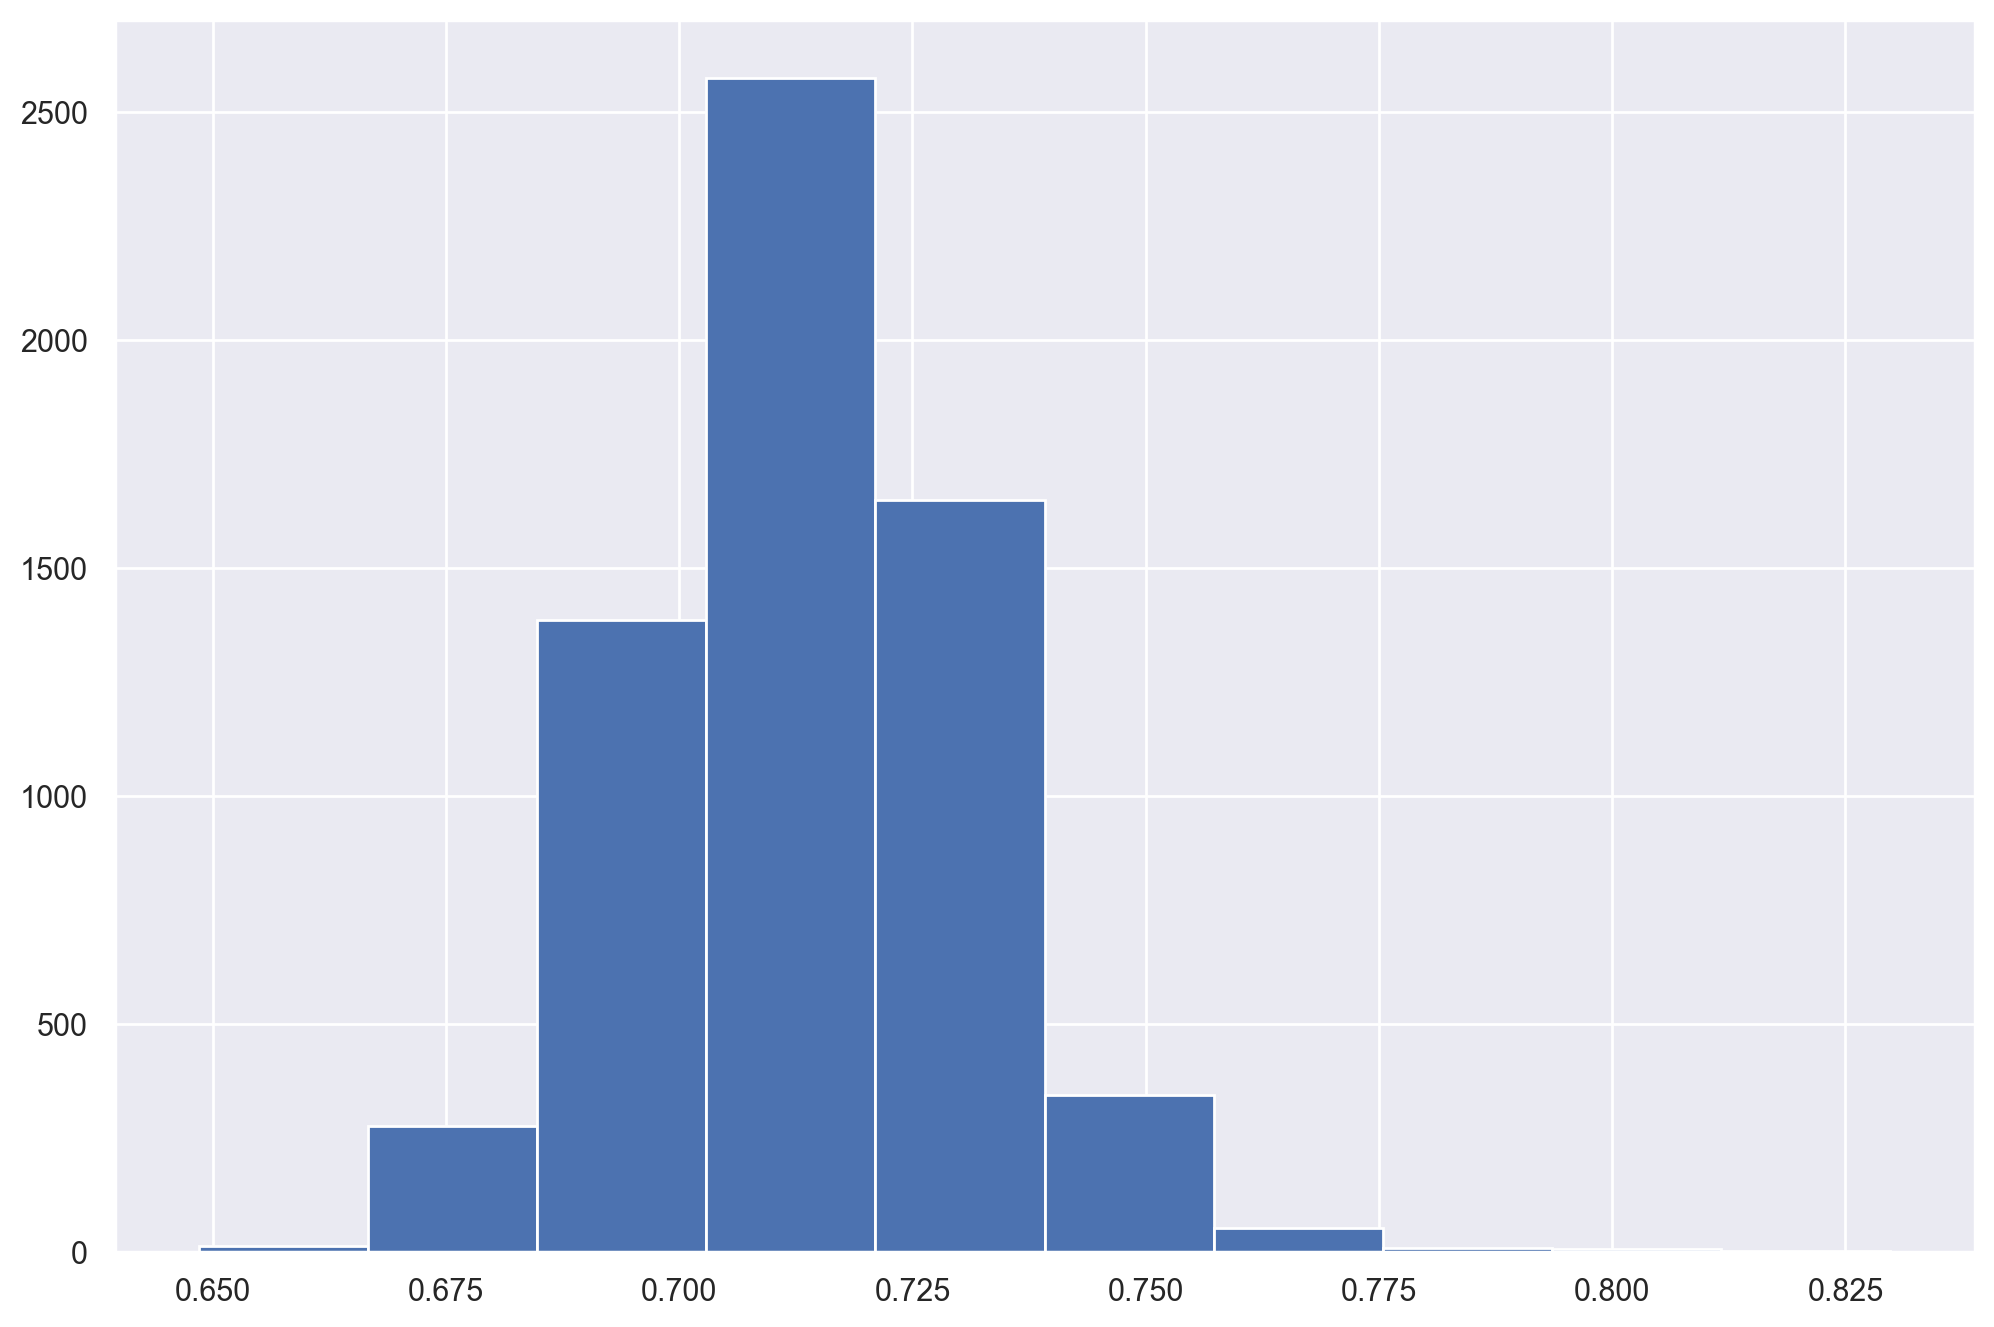

In [134]:
plt.hist(df['similarities'])

In [121]:
df['selected'] = df['similarities'] > 0.77
df['unselected'] = df['similarities'] < 0.77
df['scaled'] = df['similarities'] + df['selected'] * 20.0

In [122]:
sns.set_theme(rc={'figure.figsize':(12,8)})

(-76.63556900024415, 77.22197952270508, -77.83106632232666, 68.26965351104737)

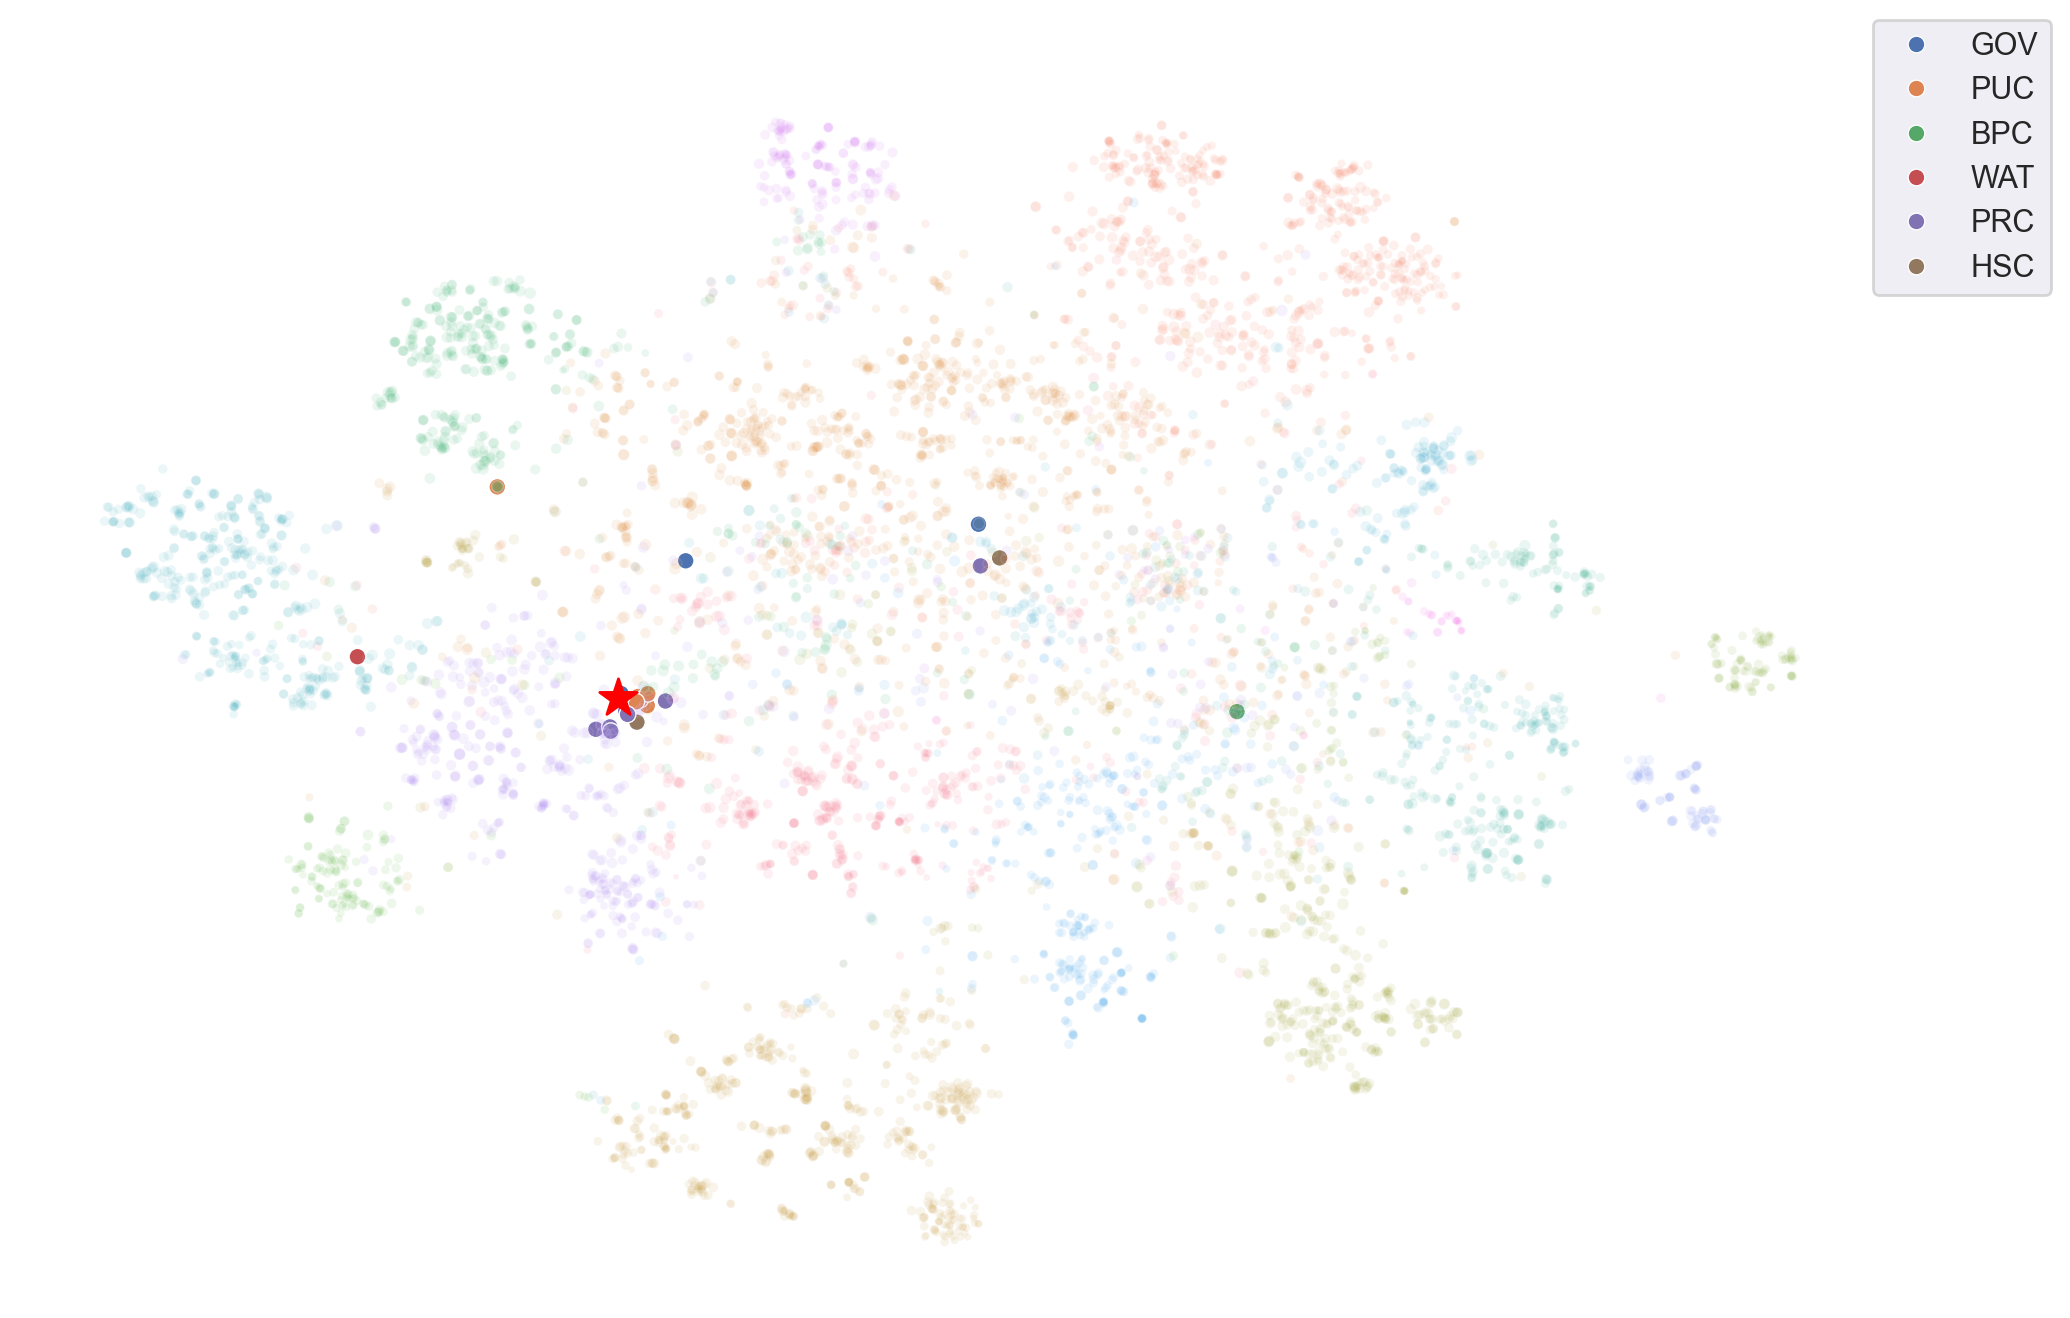

In [123]:
axes = sns.scatterplot(df[df['selected']], x='x1', y='x2', hue='-lawCode')
axes = sns.scatterplot(df[df['unselected']], x='x1', y='x2', hue='-lawCode', size='scaled', marker='.', alpha=0.1, legend=False)
plt.scatter(X_embedded[-1,0], X_embedded[-1,1], color='red', marker='*', s=200, zorder=5)
axes.legend(bbox_to_anchor=(1.1, 1.05))
axes.axis('off')

In [96]:
axes.get_figure().savefig('tsne-embedding-v2-ev-incentive.pdf')

Now let's check some of the blocks that matched as most similar

In [124]:
df[df['selected']].index

Index(['-lawCode=GOV&division=3.&title=2.&part=10b.&chapter=3.12.&article=',
       '-lawCode=PUC&division=1.&title=&part=1.&chapter=8.7.&article=2.',
       '-lawCode=BPC&division=8.&title=&part=&chapter=3.&article=9.',
       '-lawCode=WAT&division=6.&title=&part=6.&chapter=7.7.&article=3.',
       '-lawCode=PUC&division=4.8.&title=&part=1.&chapter=&article=',
       '-lawCode=PRC&division=4.&title=&part=2.&chapter=1.5.&article=1.',
       '-lawCode=PUC&division=1.&title=&part=2.&chapter=6.&article=',
       '-lawCode=GOV&division=3.&title=2.&part=5.5.&chapter=2.&article=2.',
       '-lawCode=PUC&division=1.5.&title=&part=&chapter=3.&article=8.',
       '-lawCode=PUC&division=1.&title=&part=2.&chapter=7.7.&article=',
       '-lawCode=HSC&division=25.5.&title=&part=4.&chapter=&article=',
       '-lawCode=PRC&division=15.&title=&part=&chapter=7.3.&article=',
       '-lawCode=PRC&division=16.3.&title=&part=&chapter=1.&article=',
       '-lawCode=PRC&division=16.&title=&part=&chapter=4.&

In [131]:
title = 'lawCode=PUC&division=4.8.&title=&part=1.&chapter=&article='

In [132]:
with open(f'data/{title}.txt', 'r') as file:
    print(file.read())

Public Utilities Code - PUCDIVISION 4.8. PUBLICLY OWNED UTILITIES [9500 - 9520]( Division 4.8 added by Stats. 1992, Ch. 809, Sec. 2. )PART 1. Low-Income Weatherization Programs [9500 - 9508.5]( Part 1 heading added by Stats. 2011, Ch. 580, Sec. 1. )9500.(a) Each publicly owned electric and gas utility that  provides the energy for space heating for low-income customers shall also provide home weatherization services for those customers if a significant need for those services exists in the utility’s service territory, as determined by the utility, taking into consideration both the cost-effectiveness of the services and the public policy of reducing financial hardships facing low-income households.  Publicly owned utilities shall not have to duplicate low-income home weatherization services provided by gas and electrical corporations serving the same service territory.(b) (1) For purposes of this section, “weatherization” includes, where feasible, any of the following measures for any 